# Transfter training with VGG and flower dataset
This is a transfer training practice with keras built-in VGG16 model and the flower dataset on kaggle.  
I also randomly pick up some images from google for the tiny test dataset. The weights used in this model is `imagenet` 

### Environment
- Python 3.6
- Tensorflow 1.10.0
- Keras 2.1.6
- CUDA 9.0


In [1]:
from __future__ import print_function, division
from builtins import range, input

from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

Using TensorFlow backend.
/home/evan/.virtualenvs/p3env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/evan/.virtualenvs/p3env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from glob import glob

In [3]:
# Fruit 360 image: 100x100x3
IMAGE_SIZE = [100, 100]

In [4]:
epochs = 25
batch_size = 32
validation_split = 0.2

# Data preparation

In [5]:
train_dir = '../../../large_files/flowers/'

In [6]:
test_dir = '../../../large_files/flower_test/'

In [7]:
# using glob to fetch a list of images
image_list = glob(train_dir+'/*/*.jp*g')

In [8]:
# using glob to fetch a list of class names
folder = glob(train_dir+'/*')

In [9]:
len(folder)

5

In [10]:
# Using validation split and subset to seperate training/validation set
generator = ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  fill_mode = 'wrap',
  preprocessing_function=preprocess_input,
  validation_split =validation_split
)

In [11]:
train_gen = generator.flow_from_directory(train_dir,
                                          target_size=IMAGE_SIZE, 
                                          batch_size=batch_size, 
                                          shuffle=True,
                                         subset='training')

Found 3462 images belonging to 5 classes.


In [12]:
val_gen = generator.flow_from_directory(train_dir, 
                                         target_size=IMAGE_SIZE, 
                                         batch_size=batch_size, 
                                         shuffle=True,
                                        subset='validation')

Found 861 images belonging to 5 classes.


In [13]:
train_gen.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [14]:
train_gen.samples

3462

In [15]:
# initializing label list and feeding in classes/indices
labels = [None]*len(train_gen.class_indices)

for item, indice in train_gen.class_indices.items():
    labels[indice] = item

In [16]:
labels

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Model construction

In [17]:
# do not include top fully-connected layer for customized training
vgg_model = VGG16(include_top=False, input_shape = IMAGE_SIZE + [3], weights='imagenet')

In [18]:
# Do not update weights as we use imagenet weights
for layer in vgg_model.layers:
    layer.trainable = False

In [19]:
x = Flatten()(vgg_model.output)

In [20]:
# x = Dense(48, activation='relu')(x)
# x = Dropout(0.5)(x)

In [21]:
# changing the output class number to our data class numbers
prediction = Dense(len(folder),activation='softmax')(x)

In [22]:
model = Model(inputs=vgg_model.input, outputs=prediction)

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [24]:
model.compile(
    optimizer='Adam', 
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [25]:
result = model.fit_generator(generator=train_gen, 
                    steps_per_epoch = train_gen.samples//batch_size,
                    epochs=epochs, 
                    validation_data=val_gen,
                    validation_steps=val_gen.samples//batch_size,
                    shuffle=True)

Epoch 1/25
108/108 [==============================] - 39s 357ms/step - loss: 4.9082 - acc: 0.5729 - val_loss: 3.6324 - val_acc: 0.6678
Epoch 2/25
108/108 [==============================] - 29s 269ms/step - loss: 3.2814 - acc: 0.7052 - val_loss: 3.4165 - val_acc: 0.7027
Epoch 3/25
108/108 [==============================] - 29s 267ms/step - loss: 3.1435 - acc: 0.7279 - val_loss: 3.5960 - val_acc: 0.7073
Epoch 4/25
108/108 [==============================] - 29s 267ms/step - loss: 2.9596 - acc: 0.7458 - val_loss: 3.4535 - val_acc: 0.7108
Epoch 5/25
108/108 [==============================] - 29s 271ms/step - loss: 2.8614 - acc: 0.7655 - val_loss: 3.6359 - val_acc: 0.7096
Epoch 6/25
108/108 [==============================] - 30s 281ms/step - loss: 2.6393 - acc: 0.7801 - val_loss: 3.1609 - val_acc: 0.7468
Epoch 7/25
108/108 [==============================] - 28s 261ms/step - loss: 2.7708 - acc: 0.7683 - val_loss: 3.3029 - val_acc: 0.7340
Epoch 8/25
108/108 [==============================] - 2

In [26]:
model.save('vgg_flower_50epoch_100.h5')

# Result and confusion matrix

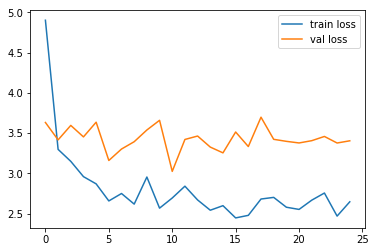

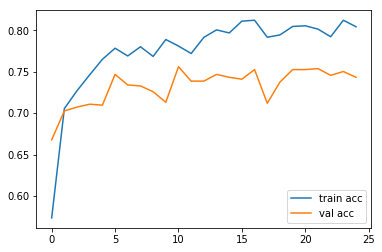

In [27]:
# loss
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(result.history['acc'], label='train acc')
plt.plot(result.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [28]:
def get_conf_matrix(data_dir, size):
    predictions =[]
    true_y = []

    for x,y in generator.flow_from_directory(data_dir, batch_size=5, target_size=IMAGE_SIZE,shuffle=False):
        prediction = model.predict(x)
        
        # decoding one-hot
        prediction = np.argmax(prediction, axis=1)
        y = np.argmax(y, axis =1)
        
        predictions = np.concatenate((predictions, prediction))
        true_y = np.concatenate((true_y, y))
        if len(predictions) >=size:
            break
    matrix = confusion_matrix(true_y, predictions)
    return matrix

In [29]:
from keras.models import load_model

In [30]:
model =load_model('vgg_flower_50epoch_100.h5')

In [31]:
# test on a tiny test set
test_img_list = glob(test_dir+'*/*.jp*g')

In [32]:
len(test_img_list)

25

In [33]:
conf_matrix = get_conf_matrix(test_dir, len(test_img_list))

Found 25 images belonging to 5 classes.


In [34]:
print(conf_matrix)

[[4 0 0 1 0]
 [0 5 0 0 0]
 [0 0 5 0 0]
 [0 0 0 5 0]
 [0 0 0 0 5]]


In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4 0 0 1 0]
 [0 5 0 0 0]
 [0 0 5 0 0]
 [0 0 0 5 0]
 [0 0 0 0 5]]


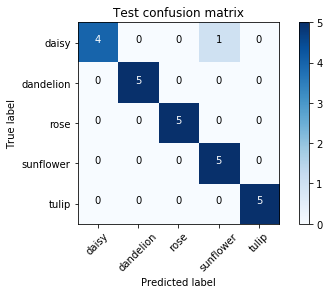

In [36]:
plot_confusion_matrix(conf_matrix, labels, title = "Test confusion matrix")

In [37]:
from keras import backend as K
K.clear_session()